# GROUP Assigntment 1 TUT11-ASSIGNMENTGRP-11
# SID :5400528987
# SID :540798188


In [51]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [52]:
import requests
import pandas as pd
from tqdm import tqdm 
from bs4 import BeautifulSoup
import os
import mimetypes
import numpy as np
import os
import re
import googlemaps
import uuid

# selenium method
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pyperclip

import time
from datetime import date, datetime

# analysis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# load environment file
from dotenv import load_dotenv

# duckdb
import duckdb
from collections import defaultdict


### 1. Retrieve Dataset

#### 1.1 Create Download Module

In [53]:
class DownloadFile:
    """Utility class for downloading files with progress and CER/ABS support."""

    def status_bar_api(self, api_url: str, csv_filename: str = None, status:str = None):
        """
        Download a file from API URL with progress bar.

        Args:
            api_url: Direct URL to download.
            csv_filename: Optional filename; if None, determined from URL or headers.
            status: either api or file to know this is from api or direct download
        """

        if status == 'api':
            with requests.get(api_url, stream=True) as response:
                response.raise_for_status()
                total_size = int(response.headers.get('content-length', 0))
                chunk_size = 1024 * 1024  # 1 MB chunks
                
                chunks = []
                with tqdm(total=total_size, unit='B', unit_scale=True, desc='Downloading') as pbar:
                    for chunk in response.iter_content(chunk_size=chunk_size):
                        if chunk:
                            chunks.append(chunk)
                            pbar.update(len(chunk))
                
                # Combine chunks into a single bytes object
                content = b''.join(chunks)
            
            # Save CSV if filename is provided
            if csv_filename:
                with open(csv_filename, 'wb') as f:
                    f.write(content)
            print(f"Download completed: {csv_filename}")
            return csv_filename
        else:

            response = requests.get(api_url, stream=True)
            response.raise_for_status()

            # Determine filename
            filename = csv_filename or os.path.basename(api_url)
            if "Content-Disposition" in response.headers:
                content_disposition = response.headers["Content-Disposition"]
                filename = content_disposition.split("filename=")[-1].strip('"')

            # Guess extension if missing
            if "." not in filename:
                content_type = response.headers.get("Content-Type", "")
                ext = mimetypes.guess_extension(content_type.split(";")[0].strip())
                if ext:
                    filename += ext

            total_size = int(response.headers.get("content-length", 0))
            chunk_size = 8192  # 8 KB

            with open(filename, "wb") as f, tqdm(
                total=total_size, unit="B", unit_scale=True, desc=filename
            ) as progress_bar:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    if chunk:
                        f.write(chunk)
                        progress_bar.update(len(chunk))

            print(f"Download completed: {filename}")
            return filename


    def download_from_cer(self, url: str):
        """
        Extract API URL from CER datasets using Selenium and download CSV.

        Args:
            url: CER dataset page URL.
        """
        driver = webdriver.Chrome()
        driver.get(url)
        wait = WebDriverWait(driver, 15)

        # Find and click "Copy API URL" button
        button = wait.until(
            EC.element_to_be_clickable(
                (By.XPATH, "//button[.//span[contains(text(), 'Copy API URL')]]")
            )
        )
        button.click()
        time.sleep(1)  # wait for clipboard update

        api_url = pyperclip.paste()
        driver.quit()

        cer_code = url.split("/")[-1]
        api_url = (api_url.replace("ODataDataset", "Dataset")).split("/")[:-1]
        api_url = "/".join(api_url)+f"/{cer_code}.csv"
        print("Downloading from:", api_url)

        csv_filename = f"{cer_code}.csv"
        return self.status_bar_api(api_url=api_url, csv_filename=csv_filename, status="api")

    def download_cer_markets(self, url: str):
        """
        Download CER markets CSV for power stations/projects.

        Args:
            url: CER markets page URL.
        """
        url_header = url.split('/')[2]
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all divs containing file links
        for div in soup.find_all("div", class_="cer-accordion__body__item"):
            a_tag = div.find("a", href=True)
            if a_tag:
                text = a_tag.get_text(strip=True).lower()
                if "csv" in text and "power stations" in text and "projects" in text:
                    file_href = a_tag["href"]
                    full_url = f"https://{url_header}{file_href}"
                    self.status_bar_api(api_url=full_url, status="file")

    def download_abs(self, url: str, target_text="Economy and industry"):
        """
        Download ABS data CSV based on section name.

        Args:
            url: ABS Data by Regions page URL.
            target_text: Section header to look for (default "Economy and industry").
        """
        url_header = url.split('/')[2]
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        target_div = None
        for div in soup.find_all("div", class_="file-description-link-formatter"):
            h4 = div.find("h4")
            if h4 and target_text in h4.text:
                target_div = div
                break

        if target_div:
            a_tag = target_div.find("a", href=True)
            download_url = f"https://{url_header}{a_tag['href']}"
            print("Found download URL:", download_url)
            self.status_bar_api(api_url=download_url, status="file")        


#### 1.2 Starting to Process Retrieving Data

In [54]:

def retrieve_data_set():
    download = DownloadFile()
    # first dataset
    print("Processing Download First Dataset ....")
    cer_url = "https://data.cer.gov.au/datasets/NGER/ID0243"
    download.download_from_cer(url=cer_url)
    # second dataset
    print("Processing Download Second Dataset ....")
    cer_markets_url = "https://cer.gov.au/markets/reports-and-data/large-scale-renewable-energy-data"
    download.download_cer_markets(url=cer_markets_url)
    # third dataset
    print("Processing Download Third Dataset ....")
    abs_url = "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24#data-downloads"
    download.download_abs(url=abs_url)






In [55]:
retrieve_data_set()

Processing Download First Dataset ....


Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)


Downloading: 100%|██████████| 83.3k/83.3k [00:00<00:00, 6.05MB/s]


Download completed: ID0243.csv
Processing Download Second Dataset ....


power-stations-and-projects-accredited.csv: 100%|██████████| 25.8k/25.8k [00:00<00:00, 136kB/s]


Download completed: power-stations-and-projects-accredited.csv


power-stations-and-projects-committed.csv: 100%|██████████| 1.89k/1.89k [00:00<00:00, 3.03MB/s]


Download completed: power-stations-and-projects-committed.csv


power-stations-and-projects-probable.csv: 100%|██████████| 2.22k/2.22k [00:00<00:00, 7.20MB/s]


Download completed: power-stations-and-projects-probable.csv
Processing Download Third Dataset ....
Found download URL: https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/14100DO0003_2011-24.xlsx


14100DO0003_2011-24.xlsx: 100%|██████████| 19.7M/19.7M [00:01<00:00, 13.3MB/s]


Download completed: 14100DO0003_2011-24.xlsx


### 2. Data Integration and Cleaning Data

#### 2.1 Create Cleaning Data Modular that we need

In [56]:
class cleaningData:
    def __init__(self):
        pass

    def show_null_data(self, data:pd.DataFrame):
        '''
            Showing Null Data for each column in a single dataframe

            Args:
                data: Dataframe to analyze

        '''
        null_count = data.isna().sum()
        null_percent = data.isna().sum() / len(data)
        null_percent = null_percent.apply(lambda x: f"{x:.1%}")
        print("Total Duplicated Count: ", data.duplicated().sum())
        results = pd.concat([null_count, null_percent], axis=1)
        results.columns = ['Null Total Count', 'Null Percentage']
        return results
    
    def split_categorical_numerical(self, data:pd.DataFrame):
        '''
            Spliting Categorical and Numerical Columns

            Args:
                data: Dataframe to analyze
        '''
        numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
        categorical_cols = data.select_dtypes(include=['object', 'category']).columns
        
        return numerical_cols, categorical_cols
    
    def replacing_value(self,df:pd.DataFrame, existing_value, new_value):
        '''
            Replacing value

            Args:
                df: Dataframe that need to be changed
                existing_value: value that currently exist
                new_value: value that will replace the existing value
        '''
        df.replace(existing_value, new_value, inplace=True)
        return None

    def filling_null_value(self, df:pd.DataFrame, replacing_value):
        '''
            Filling Null Value with value

            Args:
                df: Dataframe that need to be changed
                replacing_value: value that will replace the null value
        '''
        cat_imputer = SimpleImputer(strategy='constant', fill_value=replacing_value)
        df = cat_imputer.fit_transform(df)
        
    @staticmethod
    def clean_power_name(row: str) -> str:
        '''
            Clean the Power Facility Name

            Args: 
                row: the value that need to be clean using regex
        '''
        if not isinstance(row, str):
            return row

        # 1. Remove company suffixes and parentheses
        row_clean = re.sub(r"\b(Pty|Ltd|Limited|Inc)\b", "", row, flags=re.IGNORECASE)
        row_clean = re.sub(r"\(.*?\)", "", row_clean)

        # 2. Normalize all dashes to single spaces
        row_clean = re.sub(r"[-–]+", " ", row_clean)

        # 3. Remove SGU mentions
        row_clean = re.sub(r"\b[wW]\s*SGU\b", "", row_clean)

        # 4. Remove capacity mentions
        row_clean = re.sub(r"\d+\.?\d*\s*(kW|MW)", "", row_clean, flags=re.IGNORECASE)

        # 5. Remove technology keywords
        row_clean = re.sub(r"\b(Solar|Wind|Cogeneration)\b", "", row_clean, flags=re.IGNORECASE)

        # 6. Remove state codes
        row_clean = re.sub(r"\b(QLD|NSW|VIC|SA|WA|TAS|ACT|NT)\b", "", row_clean)

        # 7. Clean up multiple spaces
        row_clean = re.sub(r"\s+", " ", row_clean).strip()

        # 8. Title case the result
        return row_clean.title()
    
    def map_state(self, code):
        """Return state/territory for ABS codes (LGA or SA2)."""
        
        state_map = {
        "1": "NSW",
        "2": "VIC",
        "3": "QLD",
        "4": "SA",
        "5": "WA",
        "6": "TAS",
        "7": "NT",
        "8": "ACT",
        "9": "OT",
        "AUS": "AUS"
    }
    
        code = str(code).strip()
        
        # Direct match (AUS, 1–9)
        if code in state_map:
            return state_map[code]
        
        # Alphanumeric SA4 codes (e.g., 1GSYD → first digit = state)
        if code[0].isdigit():
            return state_map.get(code[0], "UNK")
        
        # Pure numeric codes (SA2, SA3, LGA)
        if code.isdigit():
            num = int(code)
            if num < 20000:   # NSW
                return "NSW"
            elif num < 30000: # VIC
                return "VIC"
            elif num < 40000: # QLD
                return "QLD"
            elif num < 50000: # SA
                return "SA"
            elif num < 60000: # WA
                return "WA"
            elif num < 70000: # TAS
                return "TAS"
            elif num < 80000: # NT
                return "NT"
            elif num < 90000: # ACT
                return "ACT"
            else:
                return "OT"
        
        return "UNK"
        



#### 2.2 Load all the Dataset

In [57]:

cleaning_data = cleaningData()

# ---------------------------------- Read Dataset ----------------------#
# first url file
df_nger = pd.read_csv("ID0243.csv")
    
# second url file
df_cer_1_approved = pd.read_csv("power-stations-and-projects-accredited.csv")
df_cer_1_commited = pd.read_csv("power-stations-and-projects-committed.csv")
df_cer_1_probable = pd.read_csv("power-stations-and-projects-probable.csv")

# third url file
df_abs = pd.ExcelFile("14100DO0003_2011-24.xlsx")
statistical_area = pd.read_excel(df_abs, 'Table 1', header=[6])
lga_area = pd.read_excel(df_abs, 'Table 2', header=[6])





#### 2.3 Data Exploration

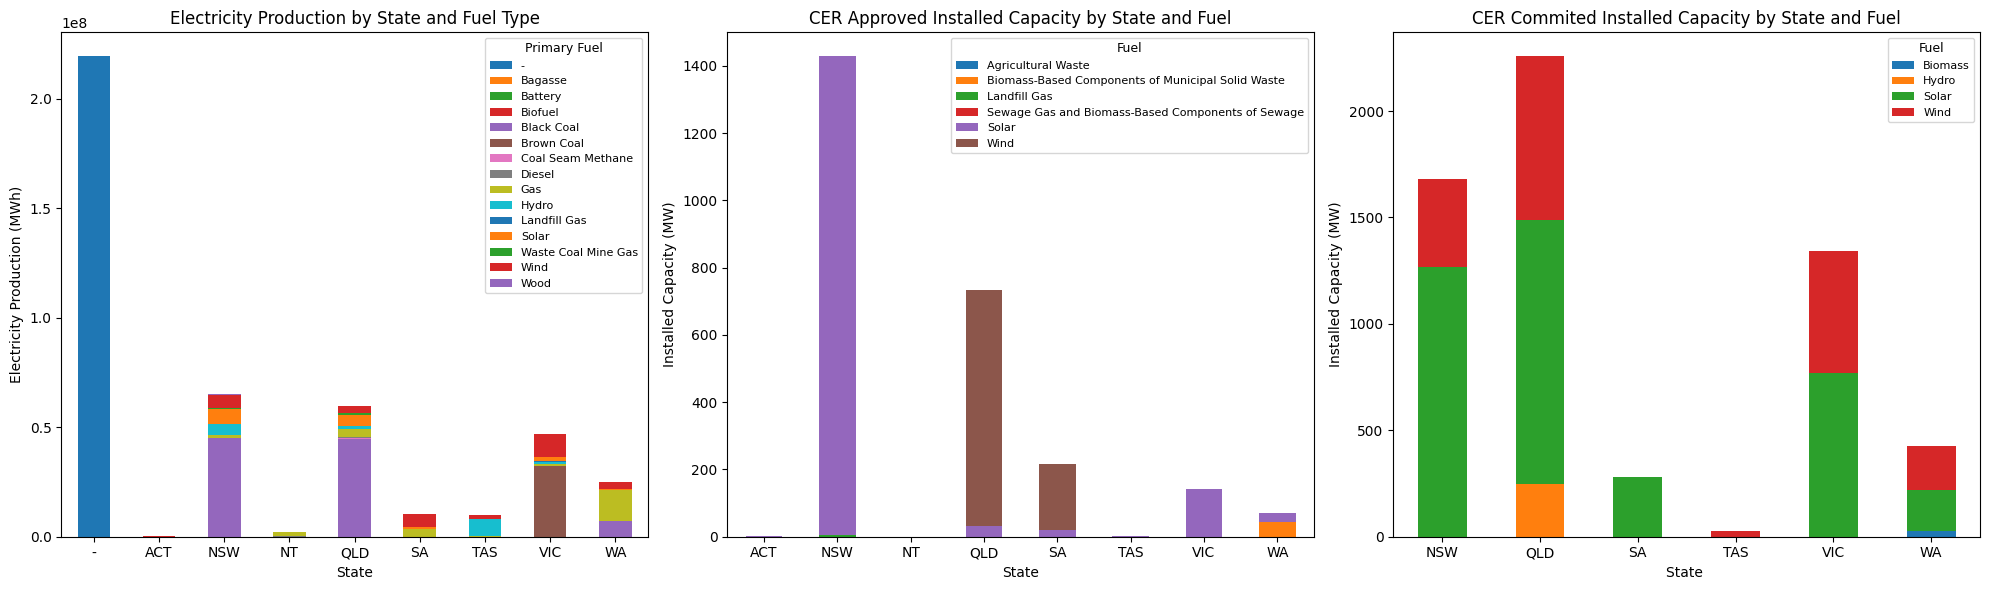

In [58]:
# Create figure with 3 subplots (vertical layout)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # width larger for horizontal space

# --- Plot 1: Electricity Production by State and Fuel Type ---
state_df = df_nger.groupby(['State','Primary fuel'])['Electricity production MWh'].sum().unstack().fillna(0)
state_df.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_ylabel("Electricity Production (MWh)")
axes[0].set_title("Electricity Production by State and Fuel Type")
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Primary Fuel', fontsize=8, title_fontsize=9)

# --- Plot 2: CER Approved Installed Capacity by State and Fuel ---
state_fuel_df_approved = df_cer_1_approved.groupby(['State', 'Fuel Source (s)'])['Installed capacity (MW)'].sum().unstack().fillna(0)
state_fuel_df_approved.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_ylabel("Installed Capacity (MW)")
axes[1].set_title("CER Approved Installed Capacity by State and Fuel")
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Fuel', fontsize=8, title_fontsize=9)

# --- Plot 3: CER Commited Installed Capacity by State and Fuel ---
state_fuel_df_commited = df_cer_1_commited.groupby(['State ', 'Fuel Source'])['MW Capacity'].sum().unstack().fillna(0)
state_fuel_df_commited.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_ylabel("Installed Capacity (MW)")
axes[2].set_title("CER Commited Installed Capacity by State and Fuel")
axes[2].tick_params(axis='x', rotation=0)
axes[2].legend(title='Fuel', fontsize=8, title_fontsize=9)

plt.tight_layout()
plt.show()

#### 2.4 Cleaning Data Set

In [59]:
# ---------------------------------- Clean NGER.ID0243.csv ------------------------#


# keep the type of F only
df_nger = df_nger[df_nger['Type'] == 'F'].copy()

cleaning_data.replacing_value(df_nger, '-', np.nan)

columns_to_drop = [
    'Electricity production GJ', 
    'Total emissions t CO2 e', 
    'Reporting entity', 
    'Important notes', 
    'Grid connected',
    'Type'
]

df_nger_numerical, df_nger_categorical = cleaning_data.split_categorical_numerical(df_nger) 

cleaning_data.filling_null_value(df_nger[df_nger_categorical], "Unknown")

df_nger_cleaning = df_nger.drop(columns=columns_to_drop)

In [60]:
# ------------------------------ Cleaning CER Approved Dataset --------------#

cleaning_data.replacing_value(df_cer_1_approved, '-', np.nan)

df_cer_1_approved["power_station_name_clean"] = df_cer_1_approved["Power station name"].apply(cleaning_data.clean_power_name)


# ------------------------------ Cleaning CER Committed Dataset --------------#

cleaning_data.replacing_value(df_cer_1_commited, '-', np.nan)

if "Committed Date (Month/Year)" in df_cer_1_commited.columns:
    df_cer_1_commited["committed_date"] = pd.to_datetime(
        df_cer_1_commited["Committed Date (Month/Year)"], format="%b-%Y", errors="coerce"
    ).dt.strftime("%Y-%m-01")  # first day of the month

cleaning_data.show_null_data(df_cer_1_commited)


# ------------------------------ Cleaning CER Probable Dataset --------------#

cleaning_data.replacing_value(df_cer_1_probable, '-', np.nan)
cleaning_data.show_null_data(df_cer_1_probable)

Total Duplicated Count:  0
Total Duplicated Count:  0


,Null Total Count,Null Percentage
Project Name,0,0.0%
State,0,0.0%
MW Capacity,0,0.0%
Fuel Source,0,0.0%


In [61]:
# ------------------------------- Cleaning ABS Dataset -----------------------#

# only get the important rows
statistical_area = statistical_area.iloc[:-7]
lga_area = lga_area.iloc[:-7]

cleaning_data.replacing_value(statistical_area, '-', np.nan)

statistical_area["Year"] = pd.to_numeric(statistical_area["Year"], errors="coerce").astype("Int64") 
statistical_area['State'] = statistical_area['Code'].apply(cleaning_data.map_state)

lga_area = lga_area.drop(columns=[
    "Total number of businesses", 
    "Number of non-employing business entries",
    "Number of employing business entries: 1-4 employees",
    "Number of employing business entries: 5-19 employees",
    "Number of employing business entries: 20 or more employees",
    "Total number of business entries",
    "Number of non-employing business exits",
    "Number of employing business exits: 1-4 employees",
    "Number of employing business exits: 5-19 employees",
    "Number of employing business exits: 20 or more employees",
    "Total number of business exits",
    "Information media and telecommunications (no.)",
    "Financial and insurance services (no.)",
    "Rental, hiring and real estate services (no.)",
    "Professional, scientific and technical services (no.)",
    "Administrative and support services (no.)",
    "Public administration and safety (no.)",
    "Education and training (no.)",
    "Arts and recreation services (no.)",
    "Other services (no.)",
    "Currently unknown (no.)",
    "Number of business entries with turnover of zero to less than $50k",
    "Number of business entries with turnover of $50k to less than $200k",
    "Number of business entries with turnover of $200k to less than $2m",
    "Number of business entries with turnover of $2m to less than $5m",
    "Number of business entries with turnover of $5m to less than $10m",
    "Number of business entries with turnover of $10m or more",
    "Number of business exits with turnover of zero to less than $50k",
    "Number of business exits with turnover of $50k to less than $200k",
    "Number of business exits with turnover of $200k to less than $2m",
    "Number of business exits with turnover of $2m to less than $5m",
    "Number of business exits with turnover of $5m to less than $10m",
    "Number of business exits with turnover of $10m or more",
    "Value of private sector houses ($m)",
    "Value of private sector dwellings excluding houses ($m)",
    "Total value of private sector dwelling units ($m)",
    "Value of residential building ($m)",
    "Value of non-residential building ($m)",
    "Value of total building ($m)",
    "Number of established house transfers (no.)",
    "Median price of established house transfers ($)",
    "Number of attached dwelling transfers (no.)",
    "Median price of attached dwelling transfers ($)",
    "Debtors entering business related personal insolvencies (no.)",
    "Debtors entering non-business related personal insolvencies (no.)",
    "Total debtors entering personal insolvencies (no.)",
    "Managers (no.)",
    "Professionals (no.)",
    "Technicians and trades workers (no.)",
    "Community and personal service workers (no.)",
    "Clerical and administrative workers (no.)",
    "Sales workers (no.)",
    "Machinery operators and drivers (no.)",
    "Labourers (no.)",
    "Debtors with other or unknown occupations (no.)",
    "Area of holding - total area (ha)",
    "Dairy cattle - total (no.)",
    "Meat cattle - total (no.)",
    "Sheep and lambs - total (no.)",
    "Pigs - total (no.)",
    "Meat chickens - total (no.)",
    "Broadacre crops - total area (ha)",
    "Vegetables - total area (ha)",
    "Orchard fruit trees and nut trees (produce intended for sale) - total area - (ha)",
    "Agricultural production - total gross value ($m)",
    "Crops - total gross value ($m)",
    "Livestock slaughtered and other disposals - total gross value ($m)"
])

statistical_area = statistical_area.drop(columns=[
    "Total number of businesses", 
    "Number of non-employing business entries",
    "Number of employing business entries: 1-4 employees",
    "Number of employing business entries: 5-19 employees",
    "Number of employing business entries: 20 or more employees",
    "Total number of business entries",
    "Number of non-employing business exits",
    "Number of employing business exits: 1-4 employees",
    "Number of employing business exits: 5-19 employees",
    "Number of employing business exits: 20 or more employees",
    "Total number of business exits",
    "Information media and telecommunications (no.)",
    "Financial and insurance services (no.)",
    "Rental, hiring and real estate services (no.)",
    "Professional, scientific and technical services (no.)",
    "Administrative and support services (no.)",
    "Public administration and safety (no.)",
    "Education and training (no.)",
    "Arts and recreation services (no.)",
    "Other services (no.)",
    "Currently unknown (no.)",
    "Number of business entries with turnover of zero to less than $50k",
    "Number of business entries with turnover of $50k to less than $200k",
    "Number of business entries with turnover of $200k to less than $2m",
    "Number of business entries with turnover of $2m to less than $5m",
    "Number of business entries with turnover of $5m to less than $10m",
    "Number of business entries with turnover of $10m or more",
    "Number of business exits with turnover of zero to less than $50k",
    "Number of business exits with turnover of $50k to less than $200k",
    "Number of business exits with turnover of $200k to less than $2m",
    "Number of business exits with turnover of $2m to less than $5m",
    "Number of business exits with turnover of $5m to less than $10m",
    "Number of business exits with turnover of $10m or more",
    "Value of private sector houses ($m)",
    "Value of private sector dwellings excluding houses ($m)",
    "Total value of private sector dwelling units ($m)",
    "Value of residential building ($m)",
    "Value of non-residential building ($m)",
    "Value of total building ($m)",
    "Number of established house transfers (no.)",
    "Median price of established house transfers ($)",
    "Number of attached dwelling transfers (no.)",
    "Median price of attached dwelling transfers ($)",
    "Debtors entering business related personal insolvencies (no.)",
    "Debtors entering non-business related personal insolvencies (no.)",
    "Total debtors entering personal insolvencies (no.)",
    "Managers (no.)",
    "Professionals (no.)",
    "Technicians and trades workers (no.)",
    "Community and personal service workers (no.)",
    "Clerical and administrative workers (no.)",
    "Sales workers (no.)",
    "Machinery operators and drivers (no.)",
    "Labourers (no.)",
    "Debtors with other or unknown occupations (no.)",
    "Area of holding - total area (ha)",
    "Dairy cattle - total (no.)",
    "Meat cattle - total (no.)",
    "Sheep and lambs - total (no.)",
    "Pigs - total (no.)",
    "Meat chickens - total (no.)",
    "Broadacre crops - total area (ha)",
    "Vegetables - total area (ha)",
    "Orchard fruit trees and nut trees (produce intended for sale) - total area - (ha)",
    "Agricultural production - total gross value ($m)",
    "Crops - total gross value ($m)",
    "Livestock slaughtered and other disposals - total gross value ($m)",
    "Houses - additions (no.)",
    "Houses - removals (no.)",
    "Townhouses - additions (no.)",
    "Townhouses - removals (no.)",
    "Apartments - additions (no.)",
    "Apartments - removals (no.)",
    "Total dwelling additions (no.)",
    "Total dwelling removals (no.)"
])



cleaning_data.replacing_value(lga_area, '-', np.nan)

lga_area["Year"] = pd.to_numeric(lga_area["Year"], errors="coerce").astype("Int64") 

lga_area['State'] = lga_area['Code'].apply(cleaning_data.map_state)

statistical_area["Year"] = pd.to_numeric(statistical_area["Year"], errors="coerce").astype("Int64") 

statistical_area['State'] = statistical_area['Code'].apply(cleaning_data.map_state)



/var/folders/2h/b49chrcn56z4tf_5y0zw27740000gn/T/ipykernel_94505/4075813849.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(existing_value, new_value, inplace=True)
/var/folders/2h/b49chrcn56z4tf_5y0zw27740000gn/T/ipykernel_94505/1252239592.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  statistical_area['State'] = statistical_area['Code'].apply(cleaning_data.map_state)
/var/folders/2h/b49chrcn56z4tf_5y0zw27740000gn/T/ipykernel_94505/4075813849.py:42: FutureWarning: Downcasting behavior in `replace` is deprec

In [62]:

exclude_col = ['Code', 'Label', 'State']
# Convert all other columns to numeric
numeric_cols_lga = [c for c in lga_area.columns if c not in exclude_col]
lga_area[numeric_cols_lga] = lga_area[numeric_cols_lga].apply(pd.to_numeric, errors='coerce')

numeric_cols_stat = [c for c in statistical_area.columns if c not in exclude_col]
statistical_area[numeric_cols_stat] = statistical_area[numeric_cols_stat].apply(pd.to_numeric, errors='coerce')

### 3. Data Augmentation

#### 3.1 Create Connect to Geographic API

In [63]:
class GeoAPI:
    '''
    Class to Use as Modular for Geography API
    '''
    def __init__(self, api_key):
        '''
        Args:
            api_key: api key that need to be generated 
        '''
        self.gmaps = googlemaps.Client(key=api_key)

    def get_coordinates(self, query: str):
        """Return (lat, lon, types) or (None, None, None) if not found"""
        try:
            results = self.gmaps.geocode(query)
            if results:
                location = results[0]['geometry']['location']
                lat = location['lat']
                lon = location['lng']
                place_types = results[0].get('types', [])
                return lat, lon, place_types
        except Exception as e:
            print(f"⚠️ Error geocoding '{query}': {e}")
        return None, None, None

    def geocode_dataframe(self, df: pd.DataFrame, col_names, delay: float = 0.1):
        """
        Add latitude/longitude tuple and Place_Types columns to a DataFrame.
        
        Args:
            df: pandas DataFrame
            col_names: list of column names to use for geocoding query
            delay: float, delay between API calls to avoid rate limits
        Returns:
            DataFrame with 'geo_location' and 'Place_Types' columns added
        """
        if isinstance(col_names, str):
            col_names = [col_names]

        points, types_list = [], []

        for _, row in df.iterrows():
            query = ", ".join([str(row[col]) for col in col_names if pd.notna(row[col])])
            print(query)
            if not query:
                points.append(None)
                types_list.append(None)
                continue

            lat, lon, types_ = self.get_coordinates(query)
            
            # Just store (lat, lon)
            if lat is not None and lon is not None:
                points.append((lat, lon))  
            else:
                points.append(None)

            types_list.append(types_)
            time.sleep(delay)

        df["geo_location"] = points
        df["Place_Types"] = types_list
        return df

#### 3.2 Starting getting geo-location

The geo-location based on station name, state and station name, state, post code

In [64]:

# ------------------------------Starting Google Map API ---------------- #

# load from environment variable
# create .env file with inside :
# GOOGLE_MAPS_API_KEY=key
load_dotenv()

# Initialize Google API
API_KEY = os.getenv("GOOGLE_MAPS_API_KEY")
geo_api = GeoAPI(API_KEY)

# Geocode DataFrame
df_geo_approved = geo_api.geocode_dataframe(df_cer_1_approved, ["power_station_name_clean", "Postcode", "State"])
df_geo_commited = geo_api.geocode_dataframe(df_cer_1_commited, ["Project Name", "State "])
df_geo_probable= geo_api.geocode_dataframe(df_cer_1_probable, ["Project Name", "State "])

for col in df_geo_approved.columns:
    df_geo_approved[col] = df_geo_approved[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

for col in df_geo_commited.columns:
    df_geo_commited[col] = df_geo_commited[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

for col in df_geo_probable.columns:
    df_geo_probable[col] = df_geo_probable[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)






Laura Johnson Home, Townview, 4825, QLD
Leppington, 2179, NSW
Quakers Hillside Care Community, 2763, NSW
Rest Nominees, 3008, VIC
Retail First Mt Ommaney, 4074, QLD
Woolworths Hcfdc Heathwood, 4110, QLD
Woolworths Kings Meadow 7210, 7249, TAS
Clayton Church Homes Elizabeth Park, 5113, SA
Dalwood Children'S Home, 2092, NSW
Haighs Proprietary Salisbury South, 5106, SA
Lindt & Sprungli, 2765, NSW
Midfield Trading, 5010, SA
Wilandra Farms Clydebank, 3851, VIC
Balickera Wps, 2324, NSW
The Creeks Pipeline Company, 5259, SA
Lai Industries, 5010, SA
Clayton Church Homes Prospect, 5082, SA
Kerang Plant, 3579, VIC
Red Valley Farms, 4871, QLD
Region Group Warnbro Central, 6169, WA
Southern Steel Dandenong South, 3175, VIC
Southern Steel Pooraka, 5095, SA
Clayton Church Homes Magill, 5072, SA
Au186 Oakdale West 5B, 2178, NSW
Carosue, 6440, WA
Linfox Regency Park, 5010, SA
Pwr Hybrid Cataby, 6507, WA
Blacktown Warehouse 1, 2148, NSW
Blacktown Warehouse 2, 2148, NSW
Hcs, 4014, QLD
Intertek Townsvill

In [65]:

def is_valid(place_types):
    if not isinstance(place_types, str) or not place_types.strip():
        return 'Not Valid'
    types = [t.strip() for t in place_types.split(',')]
    return 'Valid' if 'establishment' in types or 'point_of_interest' in types else 'Not Valid'

# Check if the Places Type is valid or not
df_geo_approved['valid_flag'] = df_geo_approved['Place_Types'].apply(is_valid)
df_geo_commited['valid_flag'] = df_geo_commited['Place_Types'].apply(is_valid)
df_geo_probable['valid_flag'] = df_geo_probable['Place_Types'].apply(is_valid)

### 4. Database Design

The process how to create Database using DuckDB

#### 4.1 Creating Module for Conecting DB to Duck DB and other operations such as Create and Insert

In [66]:
class ConnectDB:
    """DuckDB database connection and operations."""

    SQL_TYPES = {
        'object': 'VARCHAR',
        'int64': 'INTEGER',
        'float64': 'DOUBLE',
        'bool': 'BOOLEAN',
        'datetime64[ns]': 'TIMESTAMP',  
        'date': 'DATE',
        'geometry': 'GEOMETRY',  
        'point': 'POINT'                
    }

    def __init__(self, db_path: str = 'mydatabase.duckdb'):
        self.db_path = db_path
        self.connection = None
        self.open()  # open immediately

    def open(self):
        """Open DuckDB connection if not already open."""
        if self.connection is None:
            self.connection = duckdb.connect(self.db_path)
            # load spatial extension
            self.connection.execute("INSTALL spatial;")
            self.connection.execute("LOAD spatial;")

    def close(self):
        """Close DuckDB connection if open."""
        if self.connection is not None:
            self.connection.close()
            self.connection = None

    def create_table(self, df: pd.DataFrame, table_name: str,
                 primary_key: str = None,
                 auto_increment: bool = False,
                 foreign_keys: dict[str, tuple[str, str]] = None,
                 column_types: dict = None,
                 not_null_foreign_keys: bool = True):
        """
        Create a DuckDB table with specified column types, auto-increment PK, and FK constraints.

        Args:
            df: pandas DataFrame (used to get column names).
            table_name: str, table name to create.
            primary_key: str, column to set as primary key.
            auto_increment: bool, whether primary key should auto-increment.
            foreign_keys: dict {col_name: (ref_table, ref_col)}.
            column_types: dict {col_name: sql_type}.
            not_null_foreign_keys: bool, if True, foreign key columns will be NOT NULL.
        """
        try:
            self.open()
            columns_sql = []

            # Create sequence for auto-increment if needed
            if auto_increment and primary_key:
                sequence_name = f"{table_name}_{primary_key}_seq"
                self.connection.execute(f"CREATE SEQUENCE IF NOT EXISTS {sequence_name} START 1;")

            for col_name in df.columns:
                # Determine SQL type
                sql_type = 'VARCHAR'
                if column_types and col_name in column_types:
                    sql_type = column_types[col_name]
                elif col_name in df.dtypes:
                    sql_type = self.SQL_TYPES.get(str(df[col_name].dtype), 'VARCHAR')

                # Use sequence for auto-increment primary key
                if auto_increment and col_name == primary_key:
                    sql_type = f'INTEGER DEFAULT nextval(\'{sequence_name}\')'

                # Apply NOT NULL for foreign keys if requested
                if foreign_keys and col_name in foreign_keys and not_null_foreign_keys:
                    sql_type += " NOT NULL"

                columns_sql.append(f'"{col_name}" {sql_type}')

            # Add primary key constraint
            if primary_key:
                columns_sql.append(f'PRIMARY KEY("{primary_key}")')

            # Add foreign key constraints
            if foreign_keys:
                for col, (ref_table, ref_col) in foreign_keys.items():
                    columns_sql.append(f'FOREIGN KEY("{col}") REFERENCES {ref_table}("{ref_col}")')

            sql = f"CREATE TABLE IF NOT EXISTS {table_name} (\n    {',\n    '.join(columns_sql)}\n);"
            print("Executing SQL:\n", sql)
            self.connection.execute(sql)
            print(f"Table '{table_name}' created successfully.")

        except Exception as e:
            print(f"Error creating table '{table_name}': {e}")
        finally:
            self.close()

    def insert_data(self, df: pd.DataFrame, table_name: str, column_map: dict):
        """Insert DataFrame into DuckDB table with optional column mapping."""
        try:
            self.open()  # ensure connection is open

            select_clause = ", ".join([f'"{df_col}" AS "{table_col}"' for df_col, table_col in column_map.items()])
            self.connection.register("df_temp", df)
            sql = f"""
                INSERT INTO {table_name} ({', '.join(column_map.values())})
                SELECT {select_clause} FROM df_temp;
            """
            self.connection.execute(sql)
            print(f"Inserted {len(df)} rows into {table_name}")
        except Exception as e:
            print("Error inserting data:", e)
        finally:
             self.close()
             
    def generate_numeric_uuid(self, existing_ids=None):
        """
        Generate a positive numeric UUID (24-bit) and ensure no duplicates
        in the provided set of existing_ids.
        """
        if existing_ids is None:
            existing_ids = set()

        attempt = 0
        while True:
            new_id = uuid.uuid4().int & 0xFFFFFF
            if new_id not in existing_ids:
                existing_ids.add(new_id)
                return new_id
            attempt += 1
            if attempt > 10:
                raise ValueError("Unable to generate a unique UUID after 10 attempts")


    def insert_dataframe_multi_table_rowwise(self, df: pd.DataFrame, tables: list, delay: float = 0.0):
        """
        Insert a DataFrame into multiple tables row by row with foreign keys.
        Uses numeric UUIDs instead of AUTOINCREMENT.
        Handles MultiIndex columns by flattening.
        Ensures parent-child FK resolution even with duplicate rows.

        Args:
            df: pandas DataFrame (source dataset)
            tables: List of table metadata dicts:
                - name: table name
                - primary_key: table PK
                - auto_increment: bool (ignored)
                - dataset_identifier: column name in dataset for linking parent-child
                - foreign_keys: {db_col: (parent_table, parent_pk, dataset_identifier_col)}
                - column_map: {df_col: db_col}
            delay: optional delay between rows
        """
        try:
            self.open()
            # Ensure spatial extension is loaded
            self.connection.execute("INSTALL spatial;")
            self.connection.execute("LOAD spatial;")

            # Flatten MultiIndex columns if present
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else str(col) for col in df.columns]

            # Store PKs for FK resolution
            pk_store = {}

            # Keep track of generated UUIDs to prevent duplicates
            generated_uuids = set()

            # Create a unique row identifier column to handle duplicates
            unique_row_id_col = "_row_identifier"
            df[unique_row_id_col] = df.index.astype(str)

            for idx, row in df.iterrows():
                for tbl in tables:
                    table_name = tbl['name']
                    primary_key = tbl.get('primary_key')
                    foreign_keys = tbl.get('foreign_keys', {})
                    column_map = tbl.get('column_map', {})
                    dataset_identifier_col = tbl.get("dataset_identifier", unique_row_id_col)

                    if not column_map:
                        column_map = {c: c for c in df.columns}

                    db_cols = []
                    values = []

                    # ----- UUID as primary key -----
                    new_id = None
                    if primary_key:
                        new_id = self.generate_numeric_uuid(existing_ids=generated_uuids)
                        db_cols.append(primary_key)
                        values.append(str(new_id))

                    for df_col, db_col in column_map.items():
                        # If MultiIndex flattened, ensure key is string
                        if isinstance(df_col, tuple):
                            df_col = '_'.join(map(str, df_col))

                        val = row.get(df_col, None)

                        # ----- FOREIGN KEY HANDLING -----
                        if db_col in foreign_keys:
                            parent_table, parent_pk, parent_identifier_col = foreign_keys[db_col]
                            if parent_table not in pk_store:
                                raise ValueError(f"Parent table '{parent_table}' not inserted yet.")

                            parent_rows = pk_store[parent_table][
                                pk_store[parent_table][parent_identifier_col] == row[parent_identifier_col]
                            ]
                            if parent_rows.empty:
                                raise ValueError(f"No parent found for row {idx} in table '{parent_table}'")
                            val = int(parent_rows[parent_pk].values[0])
                            db_cols.append(db_col)
                            values.append(str(val))
                            continue

                        # ----- DATE HANDLING -----
                        if 'date' in df_col.lower():
                            if pd.notna(val):
                                try:
                                    val_dt = pd.to_datetime(val, dayfirst=True)
                                    val = f"'{val_dt.strftime('%Y-%m-%d')}'"
                                except Exception:
                                    val = 'NULL'
                            else:
                                val = 'NULL'
                            db_cols.append(db_col)
                            values.append(str(val))
                            continue

                        # ----- SPATIAL HANDLING -----
                        if db_col.lower() == 'geo_location':
                            if pd.notna(val):
                                val_str = str(val).strip()
                                if val_str.upper().startswith("ST_POINT"):
                                    pass
                                elif val_str.upper().startswith("POINT"):
                                    coords = val_str.replace("POINT(", "").replace(")", "").split()
                                    if len(coords) == 2:
                                        val = f"ST_POINT({coords[0]}, {coords[1]})"
                                    else:
                                        val = "ST_POINT(0,0)"
                                elif val_str.startswith("(") and val_str.endswith(")"):
                                    coords = val_str.strip("()").split(",")
                                    if len(coords) == 2:
                                        lat, lon = coords[0].strip(), coords[1].strip()
                                        val = f"ST_POINT({lon}, {lat})"
                                    else:
                                        val = "ST_POINT(0,0)"
                                else:
                                    val = "ST_POINT(0,0)"
                            else:
                                val = "ST_POINT(0,0)"  # default point instead of NULL
                            db_cols.append(db_col)
                            values.append(str(val))
                            continue

                        # ----- OTHER TYPES -----
                        if pd.isna(val):
                            val = 'NULL'
                        elif isinstance(val, str):
                            val = f"'{val.replace('\'', '\'\'')}'"
                        else:
                            val = str(val)
                        db_cols.append(db_col)
                        values.append(val)

                    # ----- INSERT SQL -----
                    sql = f"""
                        INSERT INTO {table_name} ({', '.join(db_cols)})
                        VALUES ({', '.join(values)})
                    """
                    self.connection.execute(sql)

                    # ----- Store PK for FK resolution -----
                    if primary_key and new_id:
                        df_pk = pd.DataFrame([{primary_key: new_id}])
                        if dataset_identifier_col:
                            df_pk[dataset_identifier_col] = [row[dataset_identifier_col]]
                        pk_store[table_name] = (
                            pd.concat([pk_store.get(table_name, pd.DataFrame()), df_pk])
                            if table_name in pk_store else df_pk
                        )

                if delay > 0:
                    time.sleep(delay)

            print("All rows inserted successfully (UUIDs used for PKs).")

        except Exception as e:
            print("Error inserting multi-table data row-wise:", e)

        finally:
            self.close()

    def insert_dataframe_bulk_abs_autoinc(self, df: pd.DataFrame):
        """
        Bulk insert ABS dataset using auto-increment IDs.
        Ensures no duplicate 'question' or 'state_industry_data' entries.
        """
        try:
            self.open()

            required_cols = ['Code', 'Label', 'State', 'Year']
            for col in required_cols:
                if col not in df.columns:
                    raise KeyError(f"Missing required column '{col}'")

            question_cols = [c for c in df.columns if c not in required_cols]

            # Insert unique questions
            existing_questions = {
                row[0]: row[1] for row in self.connection.execute(
                    "SELECT question, question_id FROM question"
                ).fetchall()
            }

            question_map = existing_questions.copy()
            for q in question_cols:
                if q not in existing_questions:
                    self.connection.execute(
                        "INSERT INTO question (question) VALUES (?)", [q]
                    )
                    q_id = self.connection.execute(
                        "SELECT question_id FROM question WHERE question = ?", [q]
                    ).fetchone()[0]
                    question_map[q] = q_id

            # Insert unique state_industry_data 
            existing_state_data = {
                (row[0], row[1]): row[2] for row in self.connection.execute(
                    "SELECT label_code, state_code, state_data_id FROM state_industry_data"
                ).fetchall()
            }

            state_data_map = existing_state_data.copy()
            for _, row in df[required_cols].drop_duplicates().iterrows():
                key = (row['Code'], row['State'])
                if key not in existing_state_data:
                    self.connection.execute(
                        "INSERT INTO state_industry_data (label_code, label, state_code) VALUES (?, ?, ?)",
                        [row['Code'], row['Label'], row['State']]
                    )
                    s_id = self.connection.execute(
                        "SELECT state_data_id FROM state_industry_data WHERE label_code=? AND state_code=?",
                        [row['Code'], row['State']]
                    ).fetchone()[0]
                    state_data_map[key] = s_id

            # Insert list_answer_data
            for _, row in df.iterrows():
                s_id = state_data_map[(row['Code'], row['State'])]
                for q in question_cols:
                    q_id = question_map[q]
                    answer = row[q] if pd.notna(row[q]) else None
                    # Convert numeric values if possible
                    if answer is not None:
                        try:
                            answer = float(answer)
                        except:
                            answer = str(answer)
                    self.connection.execute(
                        "INSERT INTO list_answer_data (answer, question_id, state_data_id, year) VALUES (?, ?, ?, ?)",
                        [answer, q_id, s_id, row['Year']]
                    )

            print("ABS dataset inserted successfully using auto-increment IDs.")

        except Exception as e:
            print("Error inserting ABS dataset:", e)

        finally:
            self.close()


#### 4.2 Process to Create Schema of the Database

In [67]:
# module related for database
database = ConnectDB("Asgmt1.duckdb")

# -------------------------------------------- Create list of field ------------------------------ #
column_state = ['state_code', 'name']

state_abbrev = {
    "NSW": "New South Wales",
    "VIC": "Victoria",
    "QLD": "Queensland",
    "SA": "South Australia",
    "WA": "Western Australia",
    "TAS": "Tasmania",
    "NT": "Northern Territory",
    "ACT": "Australian Capital Territory",
    "OT": "Other Territories",
    "AUS": "Australia",
}

column_states = ['states_id', 'states']

column_name_facility = ['facility_id', 'state_code', 'facility_name', 'postcode', 'source']


column_name_facility_status = [
    'facility_status_id',
    'facility_id',
    'accreditation_code',
    'capacity_mw',
    'accreditation_start_date',
    'approval_date',
    'committed_date',
    'is_valid',
    'geo_location'
]
column_name_categories_question = [
    'question_id',
    'question',
    'categories_id'
]

column_name_categories = [
    'categories_id',
    'name'
]

column_name_emmission = [
    'emission_id',
    'facility_id',
    'electricity_production_mwh',
    'scope_1_emission',
    'scope_2_emission',
    'emission_intensity',
    'grid',
]

column_state_industry_data = [
    'state_data_id',
    'label_code',
    'label',
    'state_code'
]

column_list_answer_data = [
    'list_answer_id',
    'answer',
    'question_id',
    'state_data_id',
    'year'
]

df_states = pd.DataFrame(list(state_abbrev.items()), columns=["state_code", "name"])


In [68]:

# ----------------------------------- CREATE TABLE PROCESS ---------------------------- #

# Create states table
database.create_table(df = df_states, table_name="states", primary_key="state_code", foreign_keys=None)

# create facility table
database.create_table(df = pd.DataFrame(columns=column_name_facility), table_name="facility", primary_key="facility_id", auto_increment=True, foreign_keys={"state_code": ("states", "state_code")} )

# create facility status table
database.create_table(df= pd.DataFrame(columns=column_name_facility_status), auto_increment= True, table_name="facility_status", primary_key="facility_status_id", 
                      foreign_keys= {"facility_id": ("facility", "facility_id")} ,column_types = {
                                                                                                    'facility_status_id': 'INTEGER',
                                                                                                    'facility_id': 'INTEGER',
                                                                                                    'accreditation_code': 'VARCHAR',
                                                                                                    'capacity_mw': 'DOUBLE',
                                                                                                    'accreditation_start_date': 'DATE',
                                                                                                    'is_valid': 'VARCHAR',
                                                                                                    'approval_date': 'DATE',
                                                                                                    'committed_date': 'DATE'
                                                                                                }
                        )
# create emission detail table
database.create_table(df = pd.DataFrame(columns=column_name_emmission), table_name = "emission_data", primary_key = "emission_id", auto_increment=True,
                      foreign_keys={"facility_id": ("facility", "facility_id")}, column_types = {
                                                                                                    'emission_id': 'INTEGER',             
                                                                                                    'facility_id': 'INTEGER',
                                                                                                    'electricity_production_mwh':'DOUBLE',             
                                                                                                    'scope_1_emission': 'DOUBLE',         
                                                                                                    'scope_2_emission': 'DOUBLE',         
                                                                                                    'emission_intensity': 'DOUBLE',       
                                                                                                    'grid': 'VARCHAR',                  
                                                                                                    'geo_location': 'POINT'               
                                                                                                }
                        )


# create question table
database.create_table(df = pd.DataFrame(columns=column_name_categories_question), table_name = "question", auto_increment=True, primary_key="question_id", column_types={
                                                                                                    'question_id': 'INTEGER',   
                                                                                                    'question': 'VARCHAR'
                                                                                                    }
                      )

# create state industry data from abs
database.create_table(df = pd.DataFrame(columns=column_state_industry_data), table_name="state_industry_data", primary_key="state_data_id", auto_increment=True,
                      foreign_keys={"state_code":("states", "state_code")}, column_types = {
                                                                                            'state_data_id': 'INTEGER',
                                                                                            'label_code': 'VARCHAR',
                                                                                            'label': 'VARCHAR',
                                                                                            'state_code': 'VARCHAR'
                                                                                        }
                      )

# create list_answer_data
database.create_table(df = pd.DataFrame(columns = column_list_answer_data), auto_increment=True, table_name="list_answer_data", primary_key='list_answer_id',
                      foreign_keys={"question_id":("question","question_id"), "state_data_id":("state_industry_data","state_data_id")},
                      column_types={
                            'list_answer_id':'INTEGER',
                            'answer': 'DOUBLE',
                            'question_id': 'INTEGER',
                            'state_data_id': 'INTEGER',
                            'year':'INTEGER'
                      })




Executing SQL:
 CREATE TABLE IF NOT EXISTS states (
    "state_code" VARCHAR,
    "name" VARCHAR,
    PRIMARY KEY("state_code")
);
Table 'states' created successfully.
Executing SQL:
 CREATE TABLE IF NOT EXISTS facility (
    "facility_id" INTEGER DEFAULT nextval('facility_facility_id_seq'),
    "state_code" VARCHAR NOT NULL,
    "facility_name" VARCHAR,
    "postcode" VARCHAR,
    "source" VARCHAR,
    PRIMARY KEY("facility_id"),
    FOREIGN KEY("state_code") REFERENCES states("state_code")
);
Table 'facility' created successfully.
Executing SQL:
 CREATE TABLE IF NOT EXISTS facility_status (
    "facility_status_id" INTEGER DEFAULT nextval('facility_status_facility_status_id_seq'),
    "facility_id" INTEGER NOT NULL,
    "accreditation_code" VARCHAR,
    "capacity_mw" DOUBLE,
    "accreditation_start_date" DATE,
    "approval_date" DATE,
    "committed_date" DATE,
    "is_valid" VARCHAR,
    "geo_location" VARCHAR,
    PRIMARY KEY("facility_status_id"),
    FOREIGN KEY("facility_id") 

#### 4.3 Process to Insert Database from Dataset

In [69]:
# ---------------------------------- INSERT DATA PROCESS ------------------------------- # 
# ---------------------------------- INSERT STATE DATA --------------------------------- #
database.insert_data(df = df_states, table_name="states", column_map={"state_code":"state_code", "name":"name"})

# ---------------------------------- INSERT APPROVED DATA --------------------------------- #
insert_tables_facility_status_approved = [
    {
    "name": "facility",
    "primary_key": "facility_id",
    "auto_increment": True,
    "dataset_identifier": "power_station_name_clean", 
    "column_map": {
        "power_station_name_clean": "facility_name",
        "State": "state_code",
        "Postcode": "postcode",
        "Fuel Source (s)": "source"
    }
    },
    {
        "name": "facility_status",
        "primary_key": "facility_status_id",
        "auto_increment": True,
        "foreign_keys": {
            "facility_id": ("facility", "facility_id","power_station_name_clean")
        },
        "column_map": {
            "facility_id": "facility_id",
            "Installed capacity (MW)": "capacity_mw",
            "Accreditation code": "accreditation_code",
            "Approval date": "approval_date",
            "Accreditation start date": "accreditation_start_date",
            "geo_location": "geo_location",
            "valid_flag": "is_valid"
        }
    }
]

# ---------------------------------- INSERT COMMITTED DATA --------------------------------- #

insert_tables_facility_status_commited = [
    {
    "name": "facility",
    "primary_key": "facility_id",
    "auto_increment": True,
    "dataset_identifier": "Project Name", 
    "column_map": {
        "Project Name": "facility_name",
        "State ": "state_code",
        "Fuel Source": "source"
    }
    },
    {
        "name": "facility_status",
        "primary_key": "facility_status_id",
        "auto_increment": True,
        "foreign_keys": {
            "facility_id": ("facility", "facility_id", "Project Name")
        },
        "column_map": {
            "facility_id": "facility_id",
            "MW Capacity": "capacity_mw",
            "committed_date": "committed_date",
            "geo_location": "geo_location",
            "valid_flag": "is_valid"
        }
    }
]
# ---------------------------------- INSERT PROBABLE DATA --------------------------------- #

insert_tables_facility_status_probable = [
    {
    "name": "facility",
    "primary_key": "facility_id",
    "auto_increment": True,
    "dataset_identifier": "Project Name", 
    "column_map": {
        "Project Name": "facility_name",
        "State ": "state_code",
        "Fuel Source": "source"
    }
    },
    {
        "name": "facility_status",
        "primary_key": "facility_status_id",
        "auto_increment": True,
        "foreign_keys": {
            "facility_id": ("facility", "facility_id", "Project Name")
        },
        "column_map": {
            "facility_id": "facility_id",
            "MW Capacity": "capacity_mw",
            "geo_location": "geo_location",
            "valid_flag": "is_valid"
        }
    }
]

# ---------------------------------- INSERT NGER DATA --------------------------------- #
insert_tables_nger = [
    {
    "name": "facility",
    "primary_key": "facility_id",
    "auto_increment": True,
    "dataset_identifier": "Facility name", 
    "column_map": {
        "Facility name": "facility_name",
        "State": "state_code",
        "Primary fuel":"source"
    }
    },
    {
        "name": "emission_data",
        "primary_key": "emission_id",
        "auto_increment": True,
        "foreign_keys": {
            "facility_id": ("facility", "facility_id", "Facility name")
        },
        "column_map": {
            "facility_id": "facility_id",
            "Electricity production MWh": "electricity_production_mwh",
            "Total scope 1 emissions t CO2 e": "scope_1_emission",
            "Total scope 2 emissions t CO2 e": "scope_2_emission",
            "Emission intensity t CO2 e MWh" : "emission_intensity",
            "Grid":"grid",
        }
    }
]

Error inserting data: Constraint Error: Duplicate key "state_code: NSW" violates primary key constraint.


In [70]:
database.insert_dataframe_multi_table_rowwise(df=df_geo_approved, tables=insert_tables_facility_status_approved)
database.insert_dataframe_multi_table_rowwise(df=df_geo_commited, tables=insert_tables_facility_status_commited)
database.insert_dataframe_multi_table_rowwise(df=df_geo_probable, tables=insert_tables_facility_status_probable)
database.insert_dataframe_multi_table_rowwise(df=df_nger_cleaning, tables=insert_tables_nger)
database.insert_dataframe_bulk_abs_autoinc(lga_area)
database.insert_dataframe_bulk_abs_autoinc(statistical_area)

All rows inserted successfully (UUIDs used for PKs).
All rows inserted successfully (UUIDs used for PKs).
All rows inserted successfully (UUIDs used for PKs).
All rows inserted successfully (UUIDs used for PKs).
ABS dataset inserted successfully using auto-increment IDs.
ABS dataset inserted successfully using auto-increment IDs.
